# Pipeline Analysis

In [1]:
# Read in modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import linregress

from sklearn.metrics import r2_score
import copy


%matplotlib inline

In [2]:
from outliers import smirnov_grubbs as grubbs

#define data
data = np.array([5, 14, 15, 15, 14, 19, 17, 16, 20, 22, 8, 21, 28, 11, 9, 29, 40])

#perform Grubbs' test
grubbs.test(data, alpha=.05)

array([ 5, 14, 15, 15, 14, 19, 17, 16, 20, 22,  8, 21, 28, 11,  9, 29])

### Dixon's Q

In [3]:
# found dixon's test at https://sebastianraschka.com/Articles/2014_dixon_test.html#implementing-a-dixon-q-test-function
# no need to re-invent the wheel

# dictionary to look up the critical Q-values (dictionary values)
# for different sample sizes 3+

q90 = [0.941, 0.765, 0.642, 0.56, 0.507, 0.468, 0.437,
       0.412, 0.392, 0.376, 0.361, 0.349, 0.338, 0.329,
       0.32, 0.313, 0.306, 0.3, 0.295, 0.29, 0.285, 0.281,
       0.277, 0.273, 0.269, 0.266, 0.263, 0.26
      ]

q95 = [0.97, 0.829, 0.71, 0.625, 0.568, 0.526, 0.493, 0.466,
       0.444, 0.426, 0.41, 0.396, 0.384, 0.374, 0.365, 0.356,
       0.349, 0.342, 0.337, 0.331, 0.326, 0.321, 0.317, 0.312,
       0.308, 0.305, 0.301, 0.29
      ]

q99 = [0.994, 0.926, 0.821, 0.74, 0.68, 0.634, 0.598, 0.568,
       0.542, 0.522, 0.503, 0.488, 0.475, 0.463, 0.452, 0.442,
       0.433, 0.425, 0.418, 0.411, 0.404, 0.399, 0.393, 0.388,
       0.384, 0.38, 0.376, 0.372
       ]

Q90 = {n:q for n,q in zip(range(3,len(q90)+1), q90)}
Q95 = {n:q for n,q in zip(range(3,len(q95)+1), q95)}
Q99 = {n:q for n,q in zip(range(3,len(q99)+1), q99)}


def dixon_test(data, left=True, right=True, q_dict=Q95):
    """
    Keyword arguments:
        data = A ordered or unordered list of data points (int or float).
        left = Q-test of minimum value in the ordered list if True.
        right = Q-test of maximum value in the ordered list if True.
        q_dict = A dictionary of Q-values for a given confidence level,
            where the dict. keys are sample sizes N, and the associated values
            are the corresponding critical Q values. E.g.,
            {3: 0.97, 4: 0.829, 5: 0.71, 6: 0.625, ...}

    Returns a list of 2 values for the outliers, or None.
    E.g.,
       for [1,1,1] -> [None, None]
       for [5,1,1] -> [None, 5]
       for [5,1,5] -> [1, None]

    """
    assert(left or right), 'At least one of the variables, `left` or `right`, must be True.'
    assert(len(data) >= 3), 'At least 3 data points are required'
    assert(len(data) <= max(q_dict.keys())), 'Sample size too large'

    sdata = sorted(data)
    Q_mindiff, Q_maxdiff = (0,0), (0,0)

    if left:
        Q_min = (sdata[1] - sdata[0])
        try:
            Q_min /= (sdata[-1] - sdata[0])
        except ZeroDivisionError:
            pass
        Q_mindiff = (Q_min - q_dict[len(data)], sdata[0])

    if right:
        Q_max = abs((sdata[-2] - sdata[-1]))
        try:
            Q_max /= abs((sdata[0] - sdata[-1]))
        except ZeroDivisionError:
            pass
        Q_maxdiff = (Q_max - q_dict[len(data)], sdata[-1])

    if not Q_mindiff[0] > 0 and not Q_maxdiff[0] > 0:
        outliers = [None, None]

    elif Q_mindiff[0] == Q_maxdiff[0]:
        outliers = [Q_mindiff[1], Q_maxdiff[1]]

    elif Q_mindiff[0] > Q_maxdiff[0]:
        outliers = [Q_mindiff[1], None]

    else:
        outliers = [None, Q_maxdiff[1]]

    return outliers  

def test_dixon_test():
    test_data1 = [0.142, 0.153, 0.135, 0.002, 0.175]
    test_data2 = [0.542, 0.153, 0.135, 0.002, 0.175]

    assert(dixon_test(test_data1) == [0.002, None]), 'expect [0.002, None]'
    assert(dixon_test(test_data1, right=False) == [0.002, None]), 'expect [0.002, None]'
    assert(dixon_test(test_data2) == [None, None]), 'expect [None, None]'
    assert(dixon_test(test_data2, q_dict=Q90) == [None, 0.542]), 'expect [None, 0.542]'

test_dixon_test()

### Modifying out dataframe to add in checks

In [4]:
def get_pass_dixonsq(df, groupby_list):
    '''get the whether the observation pass dixons'q or not
    
    Parameters
    ----------
    df: pandas dataframe
         contains relevant information to test triplicates
         
    groupby_list: list
        list of variables to be grouped by
        
    Returns
    -------
    df: pandas dataframe
         pass_dixonsq added where needed
    '''
    
    df["pass_dixonsq"] = 1
    df.loc[df[df.Cq == 'Undetermined'].index, 'pass_dixonsq'] = 0

    for _, data in df.groupby(groupby_list): 
        # slice out triplicate values
        tri_vals = data['Cq_copy']

        # assigning the ones that don't pass dixonsq to be 0
        # if there are less than 3 values, automatically keeping them
        if len(tri_vals) == 3:
            dt_vals = dixon_test(tri_vals)
            if dt_vals != [None, None]:
                if None in dt_vals:
                    dt_vals.remove(None)
                for outlier in dt_vals:
                    df.loc[data[data.Cq_copy == float(outlier)].index, 'pass_dixonsq'] = 0
    return(df)

In [5]:
# get the Cq_mean
def get_cq_mean(df, groupby_list, use_dixonsq=False):
    '''get the mean of Cq triplicates
    
    Parameters
    ----------
    df: pandas dataframe
         contains relevant information to calculate the mean from Cq
    
    groupby_list: list
        list of variables to be grouped by
         
    use_dixonsq: boolean
        if true, mean is calculated accounting for dixonsq with Cq
         
    Returns
    -------
    df: pandas dataframe
         Cq_mean added and propagated
    '''
    if use_dixonsq == True:
        df['Cq_copy'] = df['Cq_copy']*df['pass_dixonsq']
    temp_cols = [x for x in groupby_list]
    temp_cols.append('Cq_copy')
    df_temp = df[temp_cols]
    mean_df = df_temp.groupby(groupby_list).apply(np.mean)
    mean_df = pd.DataFrame(mean_df)[["Cq_copy"]]
    mean_df = mean_df.rename(columns={"Cq_copy": "Cq_mean"})
    mean_df.reset_index(inplace=True) 
    df = pd.merge(df, mean_df)
    return(df)

In [6]:
# get the q_mean
def get_q_mean(df, groupby_list, use_dixonsq=False):
    '''get the mean of quantity triplicates
    
    Parameters
    ----------
    df: pandas dataframe
         contains relevant information to calculate the mean from quantity
    
    groupby_list: list
        list of variables to be grouped by
         
    use_dixonsq: boolean
        if true, mean is calculated accounting for dixonsq with quantity
         
    Returns
    -------
    df: pandas dataframe
         q_mean added and propagated
    '''
    if use_dixonsq == True:
        df['q_copy'] = df['q_copy']*df['pass_dixonsq']
    temp_cols = [x for x in groupby_list]
    temp_cols.append('q_copy')
    df_temp = df[temp_cols]
    mean_df = df_temp.groupby(groupby_list).apply(np.mean)
    mean_df = pd.DataFrame(mean_df)[["q_copy"]]
    mean_df = mean_df.rename(columns={"q_copy": "q_mean"})
    mean_df.reset_index(inplace=True) 
    df = pd.merge(df, mean_df)
    return(df)

In [7]:
# get the Cq_std
def get_cq_std(df, groupby_list, use_dixonsq=False):
    '''get the standard deviations of Cq triplicates
    
    Parameters
    ----------
    df: pandas dataframe
         contains relevant information to calculate the std from Cq
         must contain plate_id and Quantity
    
    groupby_list: list
        list of variables to be grouped by
    
    use_dixonsq: boolean
        if true, std is calculated accounting for dixonsq with Cq
         
    Returns
    -------
    df: pandas dataframe
         Cq_std added and propagated
    '''
    if use_dixonsq == True:
        df['Cq_copy'] = df['Cq_copy']*df['pass_dixonsq']
    temp_cols = [x for x in groupby_list]
    temp_cols.append('Cq_copy')
    df_temp = df[temp_cols]
    std_df = df_temp.groupby(groupby_list).apply(np.std)
    std_df = pd.DataFrame(std_df)[["Cq_copy"]]
    std_df.reset_index(inplace=True) 
    std_df = std_df.rename(columns={"Cq_copy": "Cq_std"})
    df = pd.merge(df, std_df, on=groupby_list)
    
    
    return(df)

In [8]:
# flag the checks for std
def get_std_check(df):
    '''get the standard deviations check if its too large
    
    Parameters
    ----------
    df: pandas dataframe
         contains relevant information to check the std from Cq
         must contain Cq_std
         
    Returns
    -------
    df: pandas dataframe
         Cq_std checked
    '''
    # flag the Cq_std where it is large
    def std_check(x, std_val_check):
        return (x < std_val_check)*1
    df['pass_std_check'] = df.Cq_std.apply(std_check, args=(1,))
    return(df)

In [9]:
# grabbing information for standard curve and plot it
def get_linear_info(standard_df):
    '''get the standard deviations check if its too large
    
    Parameters
    ----------
    standard_df: pandas dataframe
         must contain plate_id, Cq_mean_std_curve, log_Quantity
         
    Returns
    -------
    standard_df: pandas dataframe
         linear information added
    '''
    def compute_linear_info(plate_data):
        '''compute the information for linear regression
    
        Parameters
        ----------
        plate_data: pandas dataframe
             contains relevant information to calculate
             standard curve

        Returns
        -------
        pd.Series: pandas series
             contains slope, intercept, r2 and efficiency
        '''
        p_data = plate_data.dropna()
        x = p_data['Cq_mean_std_curve']
        y = p_data['log_Quantity']
        model = np.polyfit(x, y, 1)
        predict = np.poly1d(model)
        r2 = r2_score(y, predict(x))
        slope, intercept = model
        ##### add efficiency! 
        efficiency = (10**(-1/slope)) - 1

        # abline_values = [slope * i + intercept for i in x]
        return pd.Series([slope, intercept, r2, efficiency])#, abline_values])
    standard_curve_df = standard_df.groupby(['plate_id']).apply(compute_linear_info)
    standard_curve_df = standard_curve_df.rename(columns={0: 'slope', 1:'intercept', 2:'r2', 3:'efficiency'})
    standard_curve_df = standard_curve_df.reset_index()
    standard_df = pd.merge(standard_df,standard_curve_df)
    return(standard_df)

In [10]:
# for dixons'q i want to know about whether to include at Cq or quantity (10^Cq)

def process_standard_df(standard_df, checks_include):
    '''wrapper to process standard curve with checks
    
    Parameters
    ----------
    standard_df: pandas dataframe
         standard dataframe gets checked and added information as needed
    checks_include: string
        must be one of options in ['all', 'dixonsq_only', 'std_check_only', None]
         
    Returns
    -------
    standard_df: pandas dataframe
         information added
    '''
    use_dixonsq = False
    
    if (checks_include not in ['all', 'dixonsq_only', 'std_check_only', None]):
        raise ValueError('''invalid input, must be one of the following: 'all', 
                         'dixonsq_only', 'std_check_only'or None''')
    
    if checks_include in ['all', 'dixonsq_only']:
        use_dixonsq = True
        
    standard_df['Cq_copy'] = standard_df['Cq'].replace('Undetermined', np.nan)
    standard_df['Cq_copy'] = standard_df['Cq_copy'].astype(float)
    standard_df = get_pass_dixonsq(standard_df,["plate_id", "Quantity"])
    standard_df = get_cq_mean(standard_df, ["plate_id", "Quantity"], use_dixonsq=use_dixonsq)
    standard_df = get_cq_std(standard_df, ["plate_id", "Quantity"], use_dixonsq=use_dixonsq)
    standard_df = get_std_check(standard_df)
    
    # log the quantity
    standard_df['log_Quantity'] = standard_df.apply(lambda row: np.log10(row.Quantity), axis = 1)
    
    # what to include to calculate the standard curve
    if (checks_include in ['all', 'std_check_only']):
        standard_df['Cq_mean_std_curve'] = standard_df['Cq_mean']* standard_df['pass_std_check']
    else:
        standard_df['Cq_mean_std_curve'] = standard_df['Cq_mean']
    
    standard_df = get_linear_info(standard_df)

    return standard_df

In [11]:
def process_unknown_df(unknown_df, checks_include):
    '''wrapper to process unknown curve with checks
    
    Parameters
    ----------
    unknown_df: pandas dataframe
         unknown dataframe gets checked and added information as needed
    checks_include: string
        must be one of options in ['all', 'dixonsq_only', 'std_check_only', None]
         
    Returns
    -------
    unknown_df: pandas dataframe
         information added
    '''
    if (checks_include not in ['all', 'dixonsq_only', 'std_check_only', None]):
        raise ValueError('''invalid input, must be one of the following: 'all', 
                         'dixonsq_only', 'std_check_only'or None''')
        
    use_dixonsq = False

    unknown_df['Cq_copy'] = unknown_df['Cq'].replace('Undetermined', np.nan)
    unknown_df['Cq_copy'] = unknown_df['Cq_copy'].astype(float)
    unknown_df['q_copy'] = unknown_df['Quantity']
    
    if checks_include in ['all', 'dixonsq_only']:
        use_dixonsq = True
        
    # check whether pass dixonsq
    unknown_df = get_pass_dixonsq(unknown_df,["Sample"])
    unknown_df = get_cq_mean(unknown_df, ["Sample"], use_dixonsq=use_dixonsq)
    unknown_df = get_cq_std(unknown_df, ["Sample"], use_dixonsq=use_dixonsq)
    unknown_df = get_std_check(unknown_df)
    if checks_include in ['all', 'std_checks_only']:
        unknown_df['Cq_copy'] = unknown_df['Cq_copy']*unknown_df['pass_std_check']
        
    unknown_df = get_q_mean(unknown_df, ["Sample"], use_dixonsq=use_dixonsq)
    
    return unknown_df

In [12]:
def get_quans10(unknown_df, standard_df):
    '''get the quantities from standard curve
    
    Parameters
    ----------
    unknown_df: pandas dataframe
        unknown dataframe to get the quantities by using
        the standard curve and Cq
    standard_df: pandas dataframe
         standard dataframe to grab out the standard curve
         
    Returns
    -------
    unknown_curve: pandas dataframe
         quans10 from standard curve added
    '''
    std_curve_df = standard_df.groupby(['plate_id']).apply(np.mean)[['slope','intercept']]
    std_curve_df.reset_index(inplace=True)  
    unknown_curve = pd.merge(unknown_df,std_curve_df, on='plate_id')
    unknown_curve['quans10'] = unknown_curve.apply(lambda row: 10**(row.slope*row.Cq_copy+row.intercept), axis = 1)
    unknown_curve.loc[unknown_curve[unknown_curve.Cq_copy == 0].index, 'quans10'] = np.nan
    unknown_curve['q_diff'] = unknown_curve.apply(lambda row: row.q_mean - row.q_mean, axis = 1)
    return(unknown_curve)

# Analysis with Data

In [13]:
raw_data = pd.read_csv('QuantStudio_raw_data.csv')
N1_standard = raw_data[(raw_data['Task'][:] == 'Standard') & 
               (raw_data['Target'][:] == 'N1 Twist man') &
               (raw_data['inhibition_testing'][:] == 'N')
              ]
N1_standard = N1_standard.sort_values(by=['Quantity','plate_id'])
N1_standard = N1_standard.reset_index(drop=True)

In [14]:
N1_standard_df = process_standard_df(N1_standard, 'all')

In [15]:
N1_unknown = raw_data[(raw_data['Task'][:] == 'Unknown') & 
               (raw_data['Target'][:] == 'N1 Twist man') &
               (raw_data['inhibition_testing'][:] == 'N')
              ]
N1_unknown = N1_unknown.sort_values(by=['Sample','plate_id'])
N1_unknown = N1_unknown.reset_index(drop=True)

In [16]:
N1_unknown_df = process_unknown_df(N1_unknown, 'all')

In [17]:
N1_unknown_curve = get_quans10(N1_unknown_df, N1_standard_df)

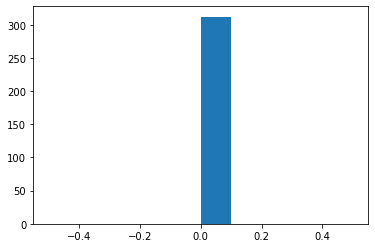

In [18]:
# hooray
with np.errstate(invalid='ignore'):
    plt.hist(N1_unknown_curve['q_diff'])

In [19]:
PMMoV_standard = raw_data[(raw_data['Task'][:] == 'Standard') & 
               (raw_data['Target'][:] == 'PMMoV Ultra man') &
               (raw_data['inhibition_testing'][:] == 'N')
              ]
PMMoV_standard = PMMoV_standard.sort_values(by=['Quantity','plate_id'])
PMMoV_standard = PMMoV_standard.reset_index(drop=True)
PMMoV_standard_df = process_standard_df(PMMoV_standard, 'all')

In [20]:
PMMoV_unknown = raw_data[(raw_data['Task'][:] == 'Unknown') & 
               (raw_data['Target'][:] == 'PMMoV Ultra man') &
               (raw_data['inhibition_testing'][:] == 'N')
              ]
PMMoV_unknown = PMMoV_unknown.sort_values(by=['Sample','plate_id'])
PMMoV_unknown = PMMoV_unknown.reset_index(drop=True)

In [21]:
PMMoV_unknown_df = process_unknown_df(PMMoV_unknown, 'all')

In [22]:
PMMoV_curve = get_quans10(PMMoV_unknown_df, PMMoV_standard_df)

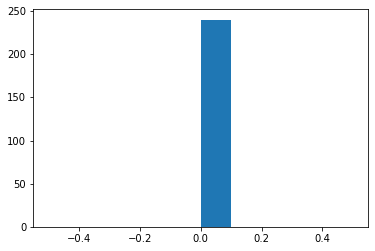

In [23]:
# hooray
with np.errstate(invalid='ignore'):
    plt.hist(PMMoV_curve['q_diff'])

In [24]:
N1_unknown_curve

,Well,Omit,Sample,Target,Dye,Task,Cq,Quantity,plate_id,inhibition_testing,...,q_copy,pass_dixonsq,Cq_mean,Cq_std,pass_std_check,q_mean,slope,intercept,quans10,q_diff
0,D7,False,1_m.o._4deg_preservation_S_minsNaCl_REP1,N1 Twist man,FAM,Unknown,30.9130579,153.039381,20.0,N,...,153.039381,1,31.072595,0.207870,1,139.294229,-0.278861,10.807000,153.654697,0.0
1,D8,False,1_m.o._4deg_preservation_S_minsNaCl_REP1,N1 Twist man,FAM,Unknown,31.3661994,114.294550,20.0,N,...,114.294550,1,31.072595,0.207870,1,139.294229,-0.278861,10.807000,114.863548,0.0
2,D9,False,1_m.o._4deg_preservation_S_minsNaCl_REP1,N1 Twist man,FAM,Unknown,30.9385285,150.548755,20.0,N,...,150.548755,1,31.072595,0.207870,1,139.294229,-0.278861,10.807000,151.162156,0.0
3,E7,False,1_m.o._4deg_preservation_S_minsNaCl_REP2,N1 Twist man,FAM,Unknown,32.0923755,71.591187,20.0,N,...,71.591187,1,32.087818,0.200899,1,72.405162,-0.278861,10.807000,72.057608,0.0
4,E8,False,1_m.o._4deg_preservation_S_minsNaCl_REP2,N1 Twist man,FAM,Unknown,31.8395201,84.256260,20.0,N,...,84.256260,1,32.087818,0.200899,1,72.405162,-0.278861,10.807000,84.760091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,G11,False,D_OSP_080420_1E,N1 Twist man,FAM,Unknown,32.6599192,74.669416,37.0,N,...,74.669416,1,32.260585,0.480151,1,100.807137,0.022934,2.178529,846.344559,0.0
353,G12,False,D_OSP_080420_1E,N1 Twist man,FAM,Unknown,32.5365404,80.710735,37.0,N,...,80.710735,1,32.260585,0.480151,1,100.807137,0.022934,2.178529,840.848309,0.0
354,F10,False,D_OSP_080420_1F,N1 Twist man,FAM,Unknown,32.9920269,60.560819,37.0,N,...,60.560819,1,32.869416,0.145755,1,65.711270,0.022934,2.178529,861.318383,0.0
355,F11,False,D_OSP_080420_1F,N1 Twist man,FAM,Unknown,32.6646121,74.448774,37.0,N,...,74.448774,1,32.869416,0.145755,1,65.711270,0.022934,2.178529,846.554325,0.0


In [25]:
PMMoV_curve[PMMoV_curve['Sample'] == '1_m.o._4deg_preservation_S_minsNaCl_REP1']

,Well,Omit,Sample,Target,Dye,Task,Cq,Quantity,plate_id,inhibition_testing,...,q_copy,pass_dixonsq,Cq_mean,Cq_std,pass_std_check,q_mean,slope,intercept,quans10,q_diff
0,D7,False,1_m.o._4deg_preservation_S_minsNaCl_REP1,PMMoV Ultra man,FAM,Unknown,22.4544988,3462035.10,22.0,N,...,3462035.10,1,14.970165,10.585505,0,2.306981e+06,-0.093139,7.57605,NaN,0.0
1,D8,False,1_m.o._4deg_preservation_S_minsNaCl_REP1,PMMoV Ultra man,FAM,Unknown,22.3160884,3763880.52,22.0,N,...,0.00,0,14.970165,10.585505,0,2.306981e+06,-0.093139,7.57605,NaN,0.0
2,D9,False,1_m.o._4deg_preservation_S_minsNaCl_REP1,PMMoV Ultra man,FAM,Unknown,22.4559956,3458906.77,22.0,N,...,3458906.77,1,14.970165,10.585505,0,2.306981e+06,-0.093139,7.57605,NaN,0.0


In [26]:
# N1_unknown_curve.to_csv('N1_unknown_curve.csv')
# PMMoV_curve.to_csv('PMMoV_curve.csv')


In [27]:
unknown = N1_unknown_curve[['Sample', 'quans10']]
unknown = unknown.rename(columns={'quans10': 'N1_unknown'})
control = PMMoV_curve[['Sample', 'quans10']]
control = control.rename(columns={'quans10': 'PMMoV'})
ratio = pd.merge(unknown[['Sample', 'N1_unknown']], 
         control[['Sample', 'PMMoV']],
         on='Sample', how='inner')
ratio = ratio.dropna()

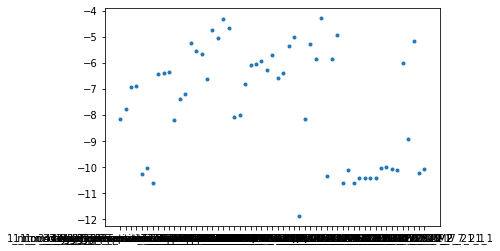

In [28]:
ratio = ratio.groupby('Sample').apply(np.mean)
ratio['log_ratio'] = np.log(ratio['N1_unknown']/ratio['PMMoV'])
plt.plot(ratio['log_ratio'],'.')

thinking adding a function model based on the model we have
for a given value 
higher concentration more variablility associated with that value